# fit_generatorで画像データの学習

画像データが格納されているフォルダからデータを読み込む  
フォルダの構成は transfer_learning_practice_osugiリポジトリのdataフォルダを参照

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dataloader import Dataloader
from solver import Solver

Using TensorFlow backend.


In [2]:
# tensorflow GPU用の設定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# データのダウンロード

In [3]:
dataloader_ins = Dataloader()

In [5]:
resize_shape = (255, 255)
dataloader_ins.get_user_data(train_dir='/data/madoka_magica_images/train', batch_size=10,
                             validation_dir='/data/madoka_magica_images/validation',
                             resize_shape=resize_shape,
                             test_dir='/data/madoka_magica_images/train', test_batch_size=1)

Found 250 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


Text(0.5, 1.0, 'ans=0')

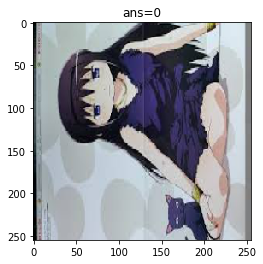

In [6]:
# 訓練データの表示
x_train, y_train = next(dataloader_ins.train_generator)
x_train, y_train = x_train[0], y_train[0]  # 1枚だけ画像を取得
ans = y_train.argmax() # one-hotから答えのラベルを取得

plt.imshow(x_train)
plt.title('ans=' + str(ans))

# モデルの定義

In [7]:
!pip install -U efficientnet==0.0.4
from usermodel_efficientnet import Usermodel_efficientnet

Requirement already up-to-date: efficientnet==0.0.4 in /usr/local/lib/python3.6/dist-packages (0.0.4)


In [8]:
# EfficinetNet
usermodel_ins = Usermodel_efficientnet(cut_size={'height': resize_shape[0], 'width': resize_shape[1]}, channel=3, category_count=5)

# 学習

In [9]:
solver_ins = Solver(dataloader_ins, usermodel_ins, n_epochs=10)

In [10]:
model = solver_ins.get_model()

input_shape : (255, 255, 3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
solver_ins.train_generator(model)


Epoch 1/10
25/25 [==============================] - 14s 577ms/step - loss: 0.2723 - categorical_accuracy: 0.7440 - val_loss: 0.4615 - val_categorical_accuracy: 0.6800
Epoch 2/10
25/25 [==============================] - 5s 193ms/step - loss: 0.1158 - categorical_accuracy: 0.9160 - val_loss: 0.6496 - val_categorical_accuracy: 0.6867
Epoch 3/10
25/25 [==============================] - 5s 191ms/step - loss: 0.1138 - categorical_accuracy: 0.9160 - val_loss: 0.1506 - val_categorical_accuracy: 0.8667
Epoch 4/10
25/25 [==============================] - 5s 192ms/step - loss: 0.0697 - categorical_accuracy: 0.9400 - val_loss: 0.0381 - val_categorical_accuracy: 0.9333
Epoch 5/10
25/25 [==============================] - 5s 195ms/step - loss: 0.0642 - categorical_accuracy: 0.9480 - val_loss: 0.4132 - val_categorical_accuracy: 0.7533
Epoch 6/10
25/25 [==============================] - 5s 210ms/step - loss: 0.0761 - categorical_accuracy: 0.9520 - val_loss: 0.1997 - val_categorical_accuracy: 0.9467
Ep

# 結果

Text(0.5, 1.0, 'pred=4, ans=4')

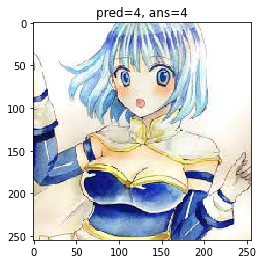

In [12]:
# テストデータの予測結果を表示
x_test, y_test = next(dataloader_ins.test_generator)
pred = model.predict(x_test) # 予測
pred_num = pred.argmax()  # one-hotから予測したラベルを取得
x_test, y_test = x_test[0], y_test[0]  # 0番目の次元を削る
ans = y_test.argmax() # one-hotから答えのラベルを取得

plt.imshow(x_test)
plt.title('pred=' + str(pred_num) + ', ans=' + str(ans))

# CAM

In [13]:
from class_activation_map import ClassActivationMap

In [14]:
# ClassActivationMap計算用クラスの作成
cam = ClassActivationMap(model, layer_GAP=-2, layer_dense=-1)

In [15]:
# CAMを計算したい画像
x_test, y_test = next(dataloader_ins.test_generator)

In [16]:
# ClassActivationMapを計算
cam_images = cam.get_class_activation_map(x_test)
cam_images.shape

(1, 8, 8, 5)

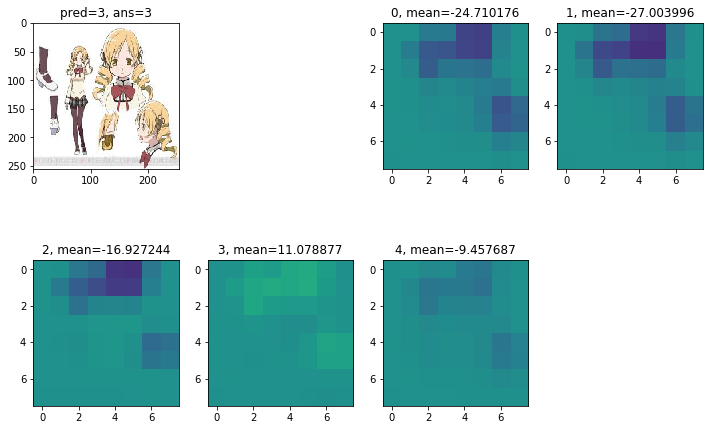

In [18]:
# 図示する画像を一枚だけ選ぶ
i = 0
image = x_test[i]
label = y_test[i]
cam_image = cam_images[i]

# 予測結果と答えを計算
pred = model.predict(image[np.newaxis, :, :, :]).argmax()  # 予測結果
ans = label.argmax()  # 答え

### 図示 ###
plt.figure(figsize=(12, 8))
# 元画像
plt.subplot(241)
plt.imshow(image)
plt.title('pred={0}, ans={1}'.format(pred, ans))
# CAM
for j in range(5):
    cam_class = cam_image[:, :, j]  # あるクラスのCAMを取得
    plt.subplot(2, 4, j+3)
    plt.imshow(cam_class, vmin=-200, vmax=200)
    plt.title(str(j) + ', mean=' + str(cam_class.mean()))  # あるクラスのCAMの平均